In [120]:
import synthetic_signal as synth
import numpy as np
import distance as distance
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from scipy.spatial.distance import cdist
from utils import transfrom_label
import plotting as plotting

In [124]:
class ValmodMotifSet(object):

    def __init__(self,n_patterns:int, min_wlen:int, max_wlen:int, p:int, radius_factor, distance_name:str, distance_params =dict())-> None:
        """Initialization

            Args:
                n_patterns (int): Number of neighbors
                min_wlen (int): Minimum window length
                max_wlen (int): Maximum window length
                p(int): minimal number of distances computed in any cases
                distance_name (str): name of the distance
                distance_params (dict, optional): additional distance parameters. Defaults to dict().
        """
        self.n_patterns = n_patterns
        self.min_wlen = min_wlen
        self.max_wlen = max_wlen
        self.p = p 
        self.radius_factor=radius_factor
        self.distance_name = distance_name
        self.distance_params = distance_params

    def CompLB(self,idx:int,i:int)->np.ndarray:
        """Compute the LowerBound of the distance between Ti,l+1 and Tj,l+1 for all j
            Args:
                idx: window length index
                i (int): considered subsequence
            returns: 
                np.ndarray: lower bounds array
        """
        wlen=self.wlens_[idx]
        next_nDP=self.n-wlen
        next_non_overlap_mask=np.arange(max(0,i-wlen), min(next_nDP,i+wlen+1))
        #we compute qi,j for all j
        q=(self.distance_[idx].dot_product_/wlen -self.distance_[idx].means_[i]*self.distance_[idx].means_)/(self.distance_[idx].stds_[i]*self.distance_[idx].stds_)
        #we truncate it because for the next wlen we have less possible subsequences  
        q=q[:next_nDP]
        
        LB=np.zeros(next_nDP)
        mask=q<=0
        LB[mask]=np.sqrt(wlen)*(self.distance_[idx].stds_[:next_nDP][mask]/self.distance_[idx+1].stds_[mask])
        LB[~mask]=np.sqrt(wlen*(1-q[~mask]**2))*(self.distance_[idx].stds_[:next_nDP][~mask]/self.distance_[idx+1].stds_[~mask])

        LB[next_non_overlap_mask]=np.inf

        return LB
    
    def ComputeMatrixProfile(self,idx:int)-> tuple:
        """Compute the Matrix Profile and the LowerBound for the length corresponding to idx
            Args:
                idx(int): window length index
            Returns: 
                MP(np.ndarray): MatrixProfile
                IP(np.ndarray: Index Profile
                listDP(list of np.ndarray): list containing for each i the successive informations:
                    -the indexes of the p minimum Dij
                    -the corresponding distances
                    -the corresponding LB
                    -the corresponding dot_products
                """
        wlen=self.wlens_[idx]
        nDP=self.n-wlen+1
        MP=np.zeros(nDP)
        IP=np.zeros(nDP).astype(int)
        listDP=[]

        line=self.distance_[idx].first_line(0)
        non_overlap_mask = np.arange(0, min(nDP,wlen))
        line[non_overlap_mask] = np.inf
        MP[0]=np.min(line)
        IP[0]=np.argmin(line)
        #we don't need the lower bound for the last index 
        if idx+1< self.wlens_.shape[0]:
            LB=self.CompLB(idx,0)
            idx_sort=np.argsort(LB)[:self.p]
            trunc_dist=line[idx_sort]
            trunc_LB=LB[idx_sort]
            trunc_dot_prod=self.distance_[idx].dot_product_[idx_sort]

            listDP.append(DP(idx_sort, trunc_dist, trunc_LB, trunc_dot_prod))

        for i in range(1,nDP):
            line=self.distance_[idx].next_line()
            non_overlap_mask = np.arange(max(0,i-self.wlens_[idx]+1), min(nDP,i+wlen))
            line[non_overlap_mask] = np.inf
            MP[i]=np.min(line)
            IP[i]=np.argmin(line)
            #we don't need the lower bound for the last index 
            if idx+1< self.wlens_.shape[0]:
                LB=self.CompLB(idx,i)
                idx_sort=np.argsort(LB)[:self.p]
                trunc_dist=line[idx_sort]
                trunc_LB=LB[idx_sort]
                trunc_dot_prod=self.distance_[idx].dot_product_[idx_sort]
                
                listDP.append(DP(idx_sort, trunc_dist, trunc_LB, trunc_dot_prod))

        return MP, IP, listDP


    def updateDistAndLB(self, idx:int, i:int, j:int,dot_product:np.ndarray, LB:np.ndarray)-> tuple:
        #should be vectorized to be more efficient
        """Update the distance and lowerbound for the sequences i and j from a length to the next one 
            Args:
                idx(int): window length index
                i(int): offset of the first subsequence (the one for which we don't know Ti,l+k)
                j(int): offset of the second subsequence (the one for which we know Tj,l+k)
                dot_product(np.ndarray): dot product QTi,j for len wlen
                LB(np.ndarray): lower bound of Di,j for len l
            Returns:
                new_distance(np.ndarray): updated Di,j for len l+k
                new_LB(np.ndarray):updated LB for len l+k
        """
        wlen=self.wlens_[idx]
        newlen=wlen+1
        new_dot_product=dot_product+self.signal_[i+newlen-1]*self.signal_[j+newlen-1]
        #we check if the increase of the length don't create an overlap
        
        if np.abs(i-j)<newlen:
            new_dist=np.inf
            new_LB=np.inf
        else:    
            new_dist=(new_dot_product-newlen*self.distance_[idx+1].means_[i]*self.distance_[idx+1].means_[j])/(newlen*self.distance_[idx+1].stds_[i]*newlen*self.distance_[idx+1].stds_[j])
            new_dist= np.sqrt(np.clip(2*(1-new_dist),0,None))
        
            new_LB= LB * self.distance_[idx].stds_[j]/self.distance_[idx+1].stds_[j]

        return new_dist, new_LB, new_dot_product
 
    def ComputeSubMP(self,idx:int)->tuple:
        """ Compute the SubMatrixProfile from the profile of len l to the profile of len l+1
            Args: 
                idx(int): window length index
            Returns:
                bBestM(Bool): indicate if the subMP is sufficient to obtain the whole MatrixProfile
                SubMP(np.ndarray): subMatrixProfile 
                IP(np.ndarray): SubIndexProfile
        """
        wlen=self.wlens_[idx]
        next_nDP=self.n-wlen
        SubMP=np.zeros(next_nDP)
        SubIP = np.zeros(next_nDP).astype(int)
        minDistAbs, minLBAbs = np.inf, np.inf
        nonValidDP=[]
        for j in range(next_nDP):
            minDist = np.inf
            DP_iter=self.listDP[j]
            #the maximum LB is at the last position
            maxLB=DP_iter.LB[-1]
            for e in range(self.p):
                i=DP_iter.idxs[e]
                if i<next_nDP:
                    #it's possible to have i>=next_nDP if we have not compute complete matrix profiles for a long time
                    dot_product=DP_iter.dot_product[e]
                    LB=DP_iter.LB[e]
                    e_dist, e_LB, e_dot_product = self.updateDistAndLB(idx,i,j,dot_product,LB)   
                    DP_iter.distance[e], DP_iter.LB[e], DP_iter.dot_product[e] = e_dist, e_LB, e_dot_product
                    minDist=min(minDist,e_dist)
                    if minDist==e_dist:
                        ind=i
            #we update DP
            self.listDP[j]=DP_iter
            if minDist<maxLB:
                minDistAbs=min(minDistAbs,minDist)
                SubMP[j]=minDist
                SubIP[j]=ind
            else:
                minLBAbs=min(minLBAbs,maxLB)
                SubMP[j]=np.inf
                nonValidDP.append([j,maxLB])
                
                
        bBestM=minDistAbs<minLBAbs
        
        if (not bBestM) and len(nonValidDP)<(next_nDP*np.log(self.p)/np.log(next_nDP)):
            for ind,maxLB in nonValidDP:
                if maxLB<minDistAbs:
                    
                    line=self.distance_[idx+1].first_line(ind)
                    non_overlap_mask = np.arange(max(0,ind-self.wlens_[idx+1]+1), min(next_nDP,ind+wlen+1))
                    line[non_overlap_mask]=np.inf
                    SubIP[ind]=np.argmin(line)
                    SubMP[ind]=np.min(line)
                    
                    if idx+2< self.wlens_.shape[0]:
                        LB=self.CompLB(idx+1,ind)
                        
                        idx_sort=np.argsort(LB)[:self.p]
                        trunc_dist=line[idx_sort]
                        trunc_LB=LB[idx_sort]
                        trunc_dot_prod=self.distance_[idx+1].dot_product_[idx_sort]
                        
                        self.listDP[ind]=(DP(idx_sort, trunc_dist, trunc_LB, trunc_dot_prod))
                    
            bBestM=True

        return bBestM,SubMP, SubIP

        
    def Valmod(self):
        """
        Compute the Variable length matrix profile (VALMP)
        """

        MP, IP, self.listDP = self.ComputeMatrixProfile(0)
        nDP=self.n-self.min_wlen+1
        self.VALMP = VALMP(nDP)
        self.bestKpairs=self.VALMP.updateVALMPForMotifSets(MP,IP,self.min_wlen,self.listDP,self.bestKpairs)

        for idx,wlen in enumerate(self.wlens_[:-1]):
            new_nDP= self.n-wlen
            self.VALMP.nDP=new_nDP
            bBestM, SubMP, SubIP = self.ComputeSubMP(idx)
            if bBestM:
                self.bestKpairs=self.VALMP.updateVALMPForMotifSets(SubMP,SubIP,wlen+1,self.listDP,self.bestKpairs)
            else:
                MP, IP, self.listDP = self.ComputeMatrixProfile(idx+1)
                self.bestKpairs=self.VALMP.updateVALMPForMotifSets(MP, IP, wlen+1,self.listDP,self.bestKpairs)

    def remove_trivial_matches(self,idxs,len):
        idxs_copy=np.copy(idxs)
        i=0
        while i < idxs_copy.shape[0]-1:
            idxs_to_remove=[]
            for j in range(i+1,idxs_copy.shape[0]):
                if np.abs(idxs_copy[i]-idxs_copy[j])<len:
                    idxs_to_remove.append(j)
            idxs_copy=np.delete(idxs_copy,idxs_to_remove)
            i+=1
        return idxs_copy

    def computeVarLengthMotifSets(self):
        non_overlap_mask=np.zeros(self.n-self.min_wlen+1).astype(bool)
        self.motifs=[]
        for pair in self.bestKpairs:
            #if we already have the right number of motifs we stop
            if len(self.motifs)>=self.n_patterns:
                break 
            #we check if we have an overlap with an already existing motif
            if any(non_overlap_mask[pair.off1:pair.off1+pair.wlen]) or any(non_overlap_mask[pair.off2:pair.off2+pair.wlen]):
                continue
            r = self.radius_factor * pair.distance
            #maxLB1= max(pair.partDP1.distance)
            #maxLB2= max(pair.partDP2.distance)
            '''if maxLB1 > r:
                print('1')
                idxs_to_keep_1=pair.partDP1.idxs[pair.partDP1.distance<=r]
            else:'''
            l_idx=np.where(self.wlens_==pair.wlen)[0][0]
            line=self.distance_[l_idx].first_line(pair.off1)
            idxs_to_keep_1=np.where(line<=r)[0]
            '''if maxLB2 > r:
                print('2')
                idxs_to_keep_2=pair.partDP2.idxs[pair.partDP2.distance<=r]
            else:'''
            l_idx=np.where(self.wlens_==pair.wlen)[0][0]
            line=self.distance_[l_idx].first_line(pair.off2)
            idxs_to_keep_2=np.where(line<=r)[0]
            idxs=np.concatenate(([pair.off1],[pair.off2],idxs_to_keep_1,idxs_to_keep_2))
            #we start by removing the indexes that overlap with already existing motifs
            new_idxs=[]
            for idx in idxs:
                if not any(non_overlap_mask[idx:idx+pair.wlen]):
                    new_idxs.append(idx)
            #then we remove trivial matches
            idxs=self.remove_trivial_matches(new_idxs,pair.wlen)
            #we update the motif list and the mask 
            new_motif=[]
            for idx in idxs:
                occurence=np.arange(idx,idx+pair.wlen)
                non_overlap_mask[occurence]=1
                new_motif.append(occurence)
            self.motifs.append(new_motif)

    def fit(self,signal):
        self.signal_=signal
        self.n=self.signal_.shape[0]
        self.distance_=[]
        self.wlens_ = np.arange(self.min_wlen,self.max_wlen+1)
        for idx,wlen in enumerate(self.wlens_):
            self.distance_.append(getattr(distance,self.distance_name)(wlen,**self.distance_params))
            self.distance_[idx].fit(self.signal_)
        self.bestKpairs=[]
        self.Valmod()
        self.bestKpairs.sort(key=Pair.get_distance)
        self.computeVarLengthMotifSets()

    @property
    def prediction_mask_(self):
        mask=np.zeros((self.n_patterns,self.signal_.shape[0]))
        for i in range(len(self.motifs)):
            motif=self.motifs[i]
            for sub_motif in motif:
                mask[i,sub_motif]=1
        return mask

class VALMP(object):
    def __init__(self, nDP:int) -> None:
        """Initialization
            Args: nDP = initial number of subsequences
        """
        self.nDP = nDP
        self.distances = np.inf * np.ones(self.nDP)
        self.normDistances = np.inf * np.ones(self.nDP)
        self.lengths = np.zeros(self.nDP)
        self.indices = np.zeros(self.nDP)

    def updateVALMPForMotifSets(self,MPnew:np.ndarray, IP:np.ndarray, wlen:int,listDP,bestKpairs) -> None:
        """Update of VALMP
            Args: 
                MPnew(np.ndarray): matrix profile for the current length
                IP(np.ndarray): index profile for the current length
                wlen(int): current length
                """
        lNormDist = MPnew / np.sqrt(wlen)
        for i in range(self.nDP):
            if lNormDist[i] < self.normDistances[i]:
                
                new_pair=Pair(i,IP[i],lNormDist[i],wlen,listDP[i],listDP[IP[i]])
                bestKpairs.append(new_pair)
                self.distances[i]=MPnew[i]
                self.normDistances[i]=lNormDist[i]
                self.lengths[i] = wlen
                self.indices[i] = IP[i]
        
        return bestKpairs
    
class DP(object):
    
    def __init__(self, idxs:np.ndarray, distance:np.ndarray, LB:np.ndarray, dot_product:np.ndarray )-> None:

        self.idxs = idxs
        self.distance = distance
        self.LB = LB
        self.dot_product =dot_product
        
class Pair(object):

    def __init__(self,off1,off2,distance,wlen,partDP1,partDP2):
        
        self.off1=off1
        self.off2=off2
        self.distance=distance
        self.wlen=wlen
        self.partDP1=partDP1
        self.partDP2=partDP2

    def get_distance(self):

        return self.distance


In [108]:
signal_generator = synth.SignalGenerator(2,max_rep=3)
signal,labels= signal_generator.generate()
signal_generator.plot()

In [126]:
self = ValmodMotifSet(2,90,110,50,15,'UnitEuclidean')
self.fit(signal)

/var/folders/dc/2vgy793x7t15h4j_f_cy_88h0000gr/T/ipykernel_36406/487842725.py:41: RuntimeWarning:

invalid value encountered in sqrt



(<Figure size 1000x400 with 1 Axes>, <Axes: >)

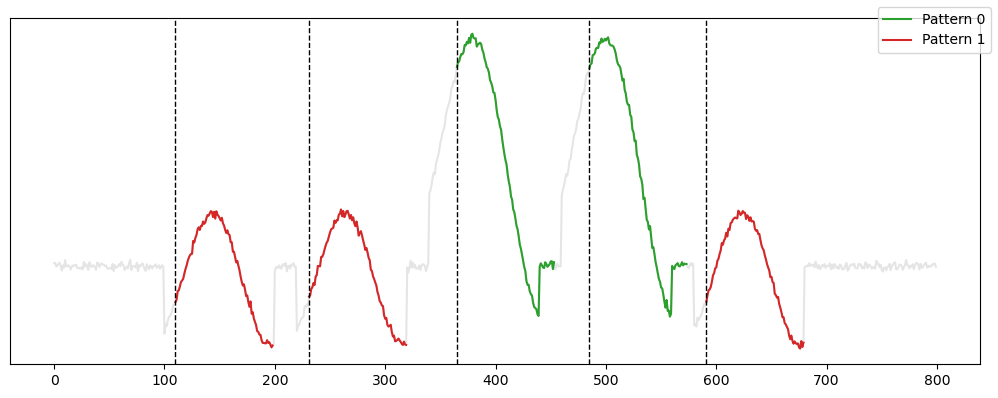

In [127]:
labels=transfrom_label(self.prediction_mask_)
plotting.plot_signal_pattern(signal,labels)